In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
import plotly.express as px

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

## Pro Tips
- decision tree-based estimators that are robust to arbitrary scaling of the data.<br>
- 

In [2]:
df = pd.read_csv('deep_learning.csv')

In [3]:
df.head()

,Number of times pregnant,glucose concentration,blood pressure,Triceps thickness,insulin level,Body mass index,Diabetes pedigree function,Age,Diabetes result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## We see 0s in our data, needs further inspection and a fix for "<u><i>some</i></u>" columns

In [4]:
df.duplicated().value_counts()  # no duplicates, all False

False    768
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Number of times pregnant    768 non-null    int64  
 1   glucose concentration       768 non-null    int64  
 2   blood pressure              768 non-null    int64  
 3   Triceps thickness           768 non-null    int64  
 4   insulin level               768 non-null    int64  
 5   Body mass index             768 non-null    float64
 6   Diabetes pedigree function  768 non-null    float64
 7   Age                         768 non-null    int64  
 8   Diabetes result             768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


<H4>Null value inspection</H4><br>
<p>but zeros are there and for some columns can't have zeros, so need to fill them, like Age for example.</p>

In [6]:
df.isnull().sum()  # no null values,

Number of times pregnant      0
glucose concentration         0
blood pressure                0
Triceps thickness             0
insulin level                 0
Body mass index               0
Diabetes pedigree function    0
Age                           0
Diabetes result               0
dtype: int64

In [7]:
cols_to_assignNan = ['glucose concentration','blood pressure', 'Triceps thickness', 'insulin level', 'Body mass index', 'Age']
df[cols_to_assignNan] = df[cols_to_assignNan].replace(0,np.NaN)

In [8]:
# now isnull can see numpy NaNs
df.isnull().sum()  # Diabetes Pedigree Function is in decimal and correlation matrix can further hint us about its importance
# numbers matched, so 0s replacement has been done successfully

Number of times pregnant        0
glucose concentration           5
blood pressure                 35
Triceps thickness             227
insulin level                 374
Body mass index                11
Diabetes pedigree function      0
Age                             0
Diabetes result                 0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff840c33810>,
      dtype=object)

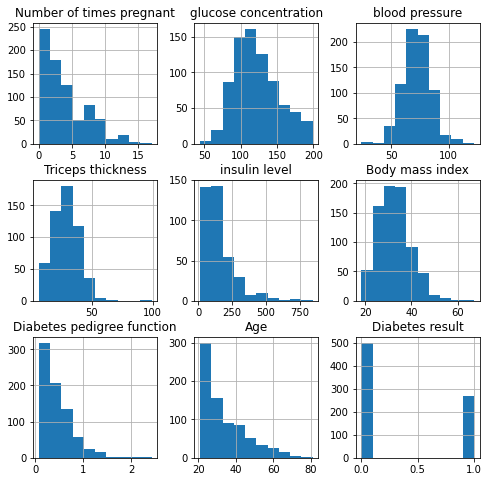

In [9]:
df.hist(figsize=(8,8))
# visualize data

## Click on legends on right to enable/disable those points from the plot, making it easier to visualize
> Also helps in figure out outliers

In [10]:
fig = px.scatter(df, facet_col='Diabetes result')  # so outliers can be seen here, with insulin level VERY high
fig.show()
fig.update_layout(title="Distribution of Data")
# individual parameters when selected shows all

# for separate plot of every parameter, loop through columns and add fig to trace
for each_col in df.columns.to_list()[:-1]:
    fig = px.scatter(df[['Diabetes result', each_col]], facet_col='Diabetes result')
    fig.show()

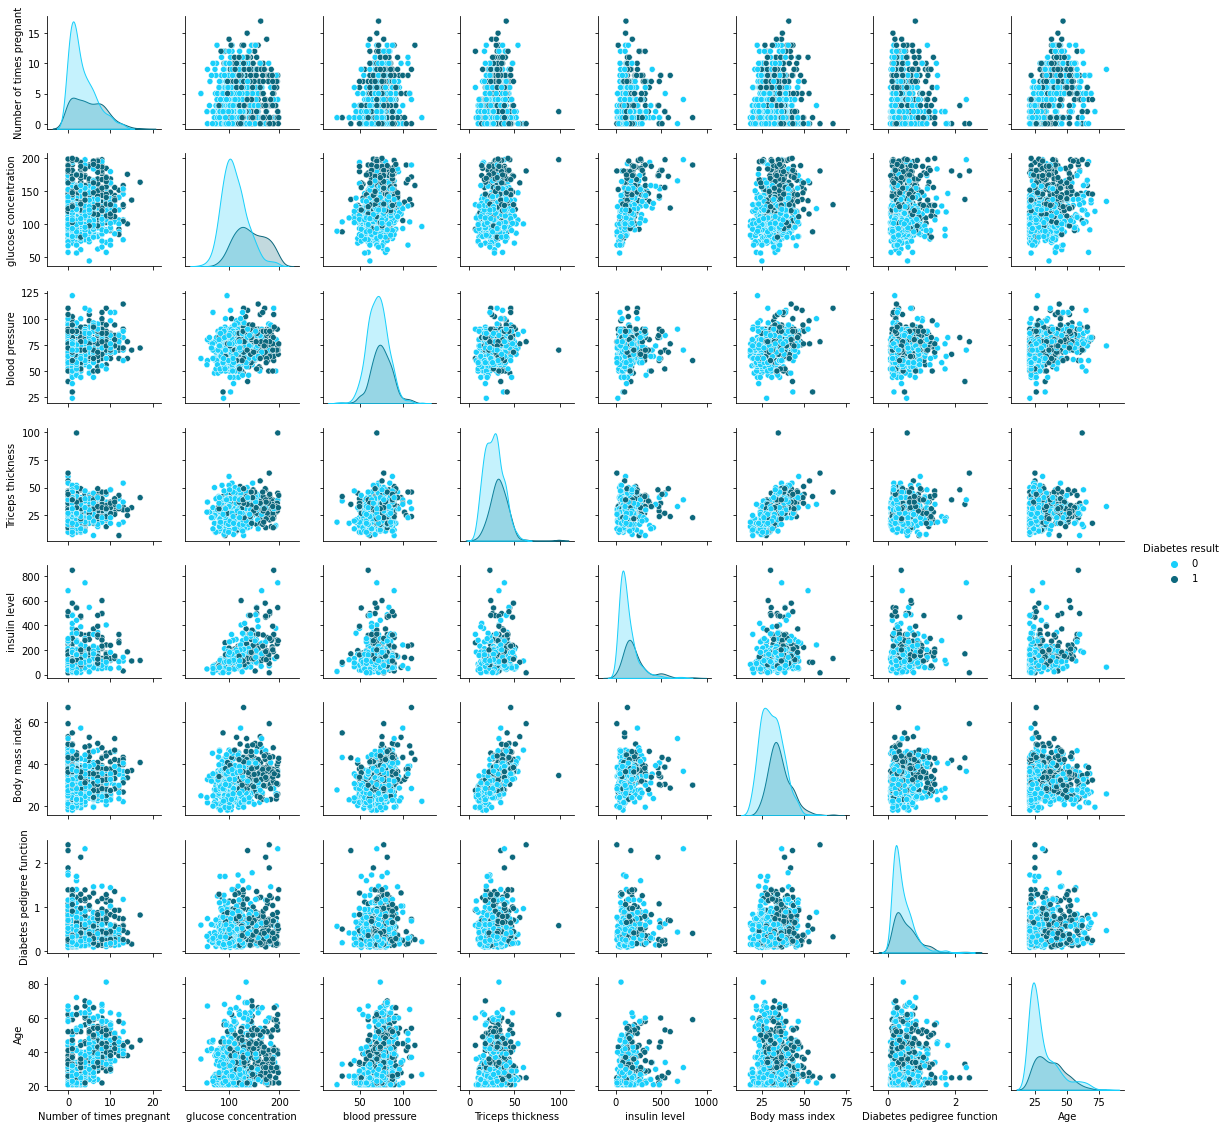

In [11]:
# comparison plot with all columns: Quick Overview of data
sns.pairplot(df, hue='Diabetes result', palette=('#19CFFB','#0D687D'), height=2, diag_kind='auto')

<h3>Some outliers in the data are:</h3>
<ol>
    <li>Tricep Thickness</li>
    <li>Insulin level</li>
    <li>BMI</li>
</ol>

## Lets fill NaNs
* We will consider two cases, those with/without diabetes fill values shall be calculated separately (Median)

In [12]:
df.pivot_table(df, index=["Diabetes result"], aggfunc=np.mean)
fig = px.bar(df.pivot_table(df, index=["Diabetes result"], aggfunc=np.mean), barmode="relative", title="Overview of Diabetic and Non-Diabetic", 
             color_discrete_sequence= px.colors.sequential.GnBu)
fig.update_layout({'paper_bgcolor':'rgba(0,0,0,0.1)', 'plot_bgcolor':'rgba(0,0,0,0.1)',})
fig.show()
# Again, legends are clickable and can be added or hide with a simple click

In [13]:
# glucose concentration           5
# blood pressure                 35
# Triceps thickness             227
# insulin level                 374
# Body mass index                11
# Only these columns 0s needs to be updated
cols_to_fill = ['glucose concentration', 'blood pressure', 'Triceps thickness', 'insulin level', 'Body mass index']
# df.loc[(df["Diabetes result"] == 0) & (df[col].isnull()), 'Age']
for col in cols_to_fill:
    df.loc[(df["Diabetes result"] == 0) & (df[col].isnull()), col] = df[df["Diabetes result"] == 0][col].median()
    df.loc[(df["Diabetes result"] == 1) & (df[col].isnull()), col] = df[df["Diabetes result"] == 1][col].median()

In [14]:
# https://towardsdatascience.com/machine-learning-for-diabetes-562dd7df4d42
# 

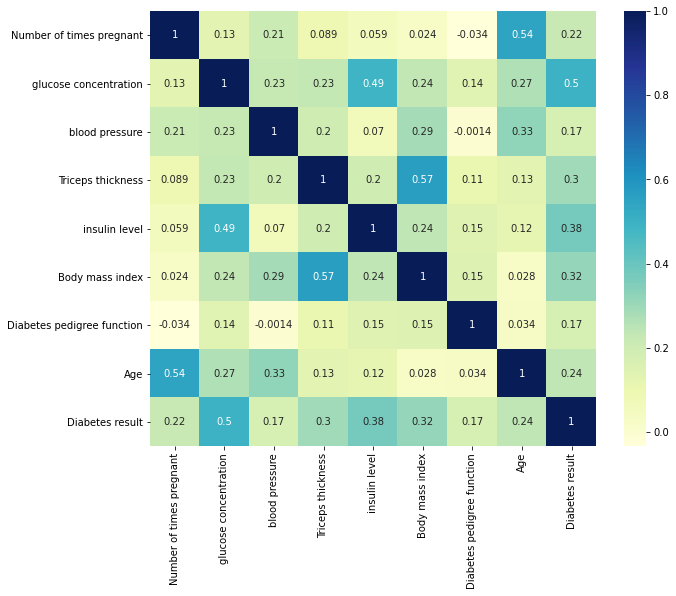

In [15]:
# correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True) 

In [16]:
df.head(10)
# now we have to categorise the columns
# [underweight, perfect, over weight, way too fatty]

,Number of times pregnant,glucose concentration,blood pressure,Triceps thickness,insulin level,Body mass index,Diabetes pedigree function,Age,Diabetes result
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,70.0,27.0,102.5,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,32.0,169.5,34.3,0.232,54,1


In [17]:
df.describe()

,Number of times pregnant,glucose concentration,blood pressure,Triceps thickness,insulin level,Body mass index,Diabetes pedigree function,Age,Diabetes result
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Feature Engineering time: 
ex: `[underweight, Healthy, overweight, Obese]` for BMI

<p>Read about low, high, optimum level for all these parameters</p>
- https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html<br>
- http://pharmwarthegame.blogspot.com/2018/11/blood-glucose-levels-chart.html<br>

In [18]:
# neglecting outliers

df.loc[(df["Body mass index"] < 18.5), "BMI_category"] = "Underweight"
df.loc[(df["Body mass index"] > 18.5) & (df["Body mass index"] <= 24.9), "BMI_category"] = "Healthy"
df.loc[(df["Body mass index"] >= 25) & (df["Body mass index"] < 30), "BMI_category"] = "Overweight"
df.loc[(df["Body mass index"] >= 30) & (df["Body mass index"] < 40), "BMI_category"] = "Obese"

# max value of Glucose in our dataset is 199
df.loc[(df["glucose concentration"] < 70), "glucose_concentration_category"] = "Low"
df.loc[(df["glucose concentration"] >= 70) & (df["glucose concentration"] < 99), "glucose_concentration_category"] = "Normal"
df.loc[(df["glucose concentration"] >= 99) & (df["glucose concentration"] < 126), "glucose_concentration_category"] = "Secret"
df.loc[(df["glucose concentration"] >= 126) & (df["glucose concentration"] < 200), "glucose_concentration_category"] = "High"

df.loc[df['Triceps thickness'] < 30, "Triceps_thickness_category"] = "Normal"
df.loc[df['Triceps thickness'] >= 30, "Triceps_thickness_category"] = "HighFat"

df.loc[df['Number of times pregnant'] == 0, "Num_pregnant_category"] = "No_Pregnancy"
df.loc[((df['Number of times pregnant'] > 0) & (df['Number of times pregnant'] <= 4)), "Num_pregnant_category"] = "Normal_Pregnancy"
df.loc[(df['Number of times pregnant'] > 4), "Num_pregnant_category"] = "High_Pregnancy"

# Age can also be categorised

# df.loc[(df['SkinThickness'] < 30) & (df['BloodPressure'] < 80), "NEW_CIRCULATION_LEVEL"] = "Normal"
# df.loc[(df['SkinThickness'] >= 30) & (df['BloodPressure'] >= 80), "NEW_CIRCULATION_LEVEL"] = "CircularAtHighRisk"
# df.loc[((df['SkinThickness'] < 30) & (df['BloodPressure'] >= 80))
#        | ((df['SkinThickness'] >= 30) & (df['BloodPressure'] < 80)), "NEW_CIRCULATION_LEVEL"] = "CircularAtMediumRisk"

# df["Pre_Age_Cat"] = df["Age"] * df["Pregnancies"]

# df["Ins_Glu_Cat"] = df["Glucose"] * df["Insulin"]

# Let's create a basic model and then will tweak it with different alogrithms

In [19]:
le = LabelEncoder()
df['Triceps_thickness_category'] = le.fit_transform(df['Triceps_thickness_category'])

In [20]:
ohe_cols = [col for col in df.columns if 10 >= len(df[col].unique()) > 2]
print(ohe_cols)

['BMI_category', 'glucose_concentration_category', 'Num_pregnant_category']


In [21]:
def one_hot_encoder(df, categorical_cols, drop_first=False):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

In [22]:
one_hot_encoder(df, ohe_cols, drop_first=True)  # while doing ohe, dropping one of the columns can help avoid correlation

,Number of times pregnant,glucose concentration,blood pressure,Triceps thickness,insulin level,Body mass index,Diabetes pedigree function,Age,Diabetes result,Triceps_thickness_category,BMI_category_Obese,BMI_category_Overweight,BMI_category_Underweight,glucose_concentration_category_Low,glucose_concentration_category_Normal,glucose_concentration_category_Secret,Num_pregnant_category_No_Pregnancy,Num_pregnant_category_Normal_Pregnancy
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,0,1,0,0,0,0,0,0,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,1,0,1,0,0,1,0,0,1
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,0,0,0,0,0,0,0,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1,0,1,0,0,1,0,0,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,0,1,0,0,0,0,1,0,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0,1,1,0,0,0,0,1,0,1
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,1,0,1,0,0,0,1,0,0
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1,0,1,0,0,0,0,0,0,1


# Final Data

In [23]:
target = df["Diabetes result"]
cols_to_drop = ohe_cols.copy()
cols_to_drop.append('Diabetes result')
X = df.drop(cols_to_drop, axis=1)  # df.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, random_state=69)  # yeahhh!

## Load ML Models
- Decision Tree <br>
- Random Forest <br>
- Gradient Boosting

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [25]:
model_dtc = DecisionTreeClassifier(random_state=17)
history = model_dtc.fit(X_train, y_train)

In [60]:
dtc_params = {
    "max_depth": range(1, 11),
    "min_samples_split": [2, 3, 4]
}

dtc_gs = GridSearchCV(model_dtc, dtc_params, cv=10, n_jobs=-1, verbose=True)
dtc_gs.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.0s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'min

In [61]:
dtc_gs.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [62]:
history_dtc = DecisionTreeClassifier(**dtc_gs.best_params_, random_state=69).fit(X_train, y_train)

In [63]:
# test error
y_pred = history_dtc.predict(X_test)
y_prob = history_dtc.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       121
           1       0.82      0.72      0.77        71

    accuracy                           0.84       192
   macro avg       0.83      0.81      0.82       192
weighted avg       0.84      0.84      0.84       192



0.8137003841229192

In [64]:
accuracy_score(y_pred, y_test)

0.8385416666666666

In [66]:
# Save model
import pickle
filename = 'descisionTreeClf_83_8.sav'
pickle.dump(history_dtc, open(filename, 'wb'))

<H3>Plot Confusion Matrix</H3>

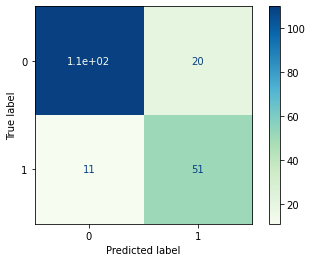

In [31]:
confusion_matrix(y_pred, y_test)
cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred,y_test,labels=[0,1]),
                              display_labels=[0,1])
cm.plot(cmap="GnBu")

### Random Forest Classifier

In [67]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(1,11),
    'criterion' :['gini', 'entropy']
}

In [70]:
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=2, verbose=1)
rf_gs.fit(X_train, y_train)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.8min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [80]:
rf_gs.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 200}

In [72]:
history_rfc = RandomForestClassifier(**rf_gs.best_params_, random_state=69).fit(X_train, y_train)

In [73]:
y_pred = history_rfc.predict(X_test)
y_prob = history_rfc.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       121
           1       0.83      0.83      0.83        71

    accuracy                           0.88       192
   macro avg       0.87      0.87      0.87       192
weighted avg       0.88      0.88      0.88       192



0.8659061808869747

In [74]:
filename = 'randomForestClf_86_6.sav'
pickle.dump(history_rfc, open(filename, 'wb'))

## This is the end of this notebook

### Gradient Boosting Classifier

In [46]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

parameters = {
    "loss":["deviance", "exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 11),
    "min_samples_leaf": np.linspace(0.1, 0.5, 11),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

### Using StratifiedKFold on `X` and `Target`, if estimator is classifier

<p> lack of time, couldn't attempt this Folding method

In [36]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, target)

2

In [ ]:
# for train_index, test_index in skf.split(X, target):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_st_train, X_st_test = X[train_index], X[test_index]
#     y_st_train, y_st_test = y[train_index], y[test_index]

Got Stratifed Train Test Data

In [49]:
gbc_gs = GridSearchCV(GradientBoostingClassifier(), parameters, scoring=scoring, refit=False, cv=5, n_jobs=-1, verbose=1)
gbc_gs.fit(X_train, y_train)

In [ ]:
# history_gbc = GradientBoostingClassifier(random_state=69)
dir(gbc_gs)

In [ ]:
accuracy_score(y_pred, y_test)
# history_gbc.predict(X_test)

0.84375

## Gradient Boosting Classifier showed improvement of 2% to Decision Tree Classifier\

In [ ]:
# save model object
filename = 'gradientBoostingClf_83_8.sav'
pickle.dump(history_rfc, open(filename, 'wb'))

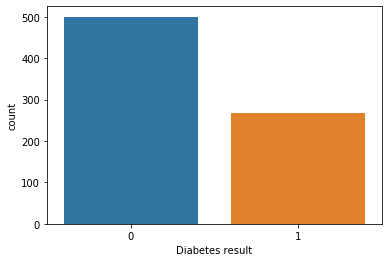

In [ ]:
sns.countplot(target)
# ok, so we have more diabetic positive patient records

<p>Glucose Concenteration and Diabetes result </p>
<ul>
    <li>Age and No. of times you get pregnant are somewhat correlated and makes sense</li>
    <li>Glucose Concenteration affects Diabetes, umm somewhat</li>
    <li>Insulin, BMI and Triceps thickness, not that highly correlated, but has some sort of connection</li>
    <li>And that's it</li>
</ul>

<H5>So, all columns are relevant in order to find the final result</H5>